In [1]:
import h5py
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib.collections import LineCollection
from IPython import display
import glob
import time
from compute_rays import compute_rays

In [2]:
# set path
path = "/home/setholinger/Documents/Projects/PIG/detections/templateMatch/multiTemplate/run3/"

# read rift and shear margin backazimuths and event times
azimuth_file = h5py.File(path + "short_3D_clustering/modified_k_shape/2/rift_and_shear_backazimuths.h5","r")
rift_backazimuths = np.array(list(azimuth_file["rift_backazimuths"]))
rift_times = np.array(list(azimuth_file["rift_times"]))
shear_backazimuths = np.array(list(azimuth_file["shear_backazimuths"]))
shear_times = np.array(list(azimuth_file["shear_times"]))
azimuth_file.close()

In [3]:
# add angle to all backazimuths to account for misalignment of imagery
image_angle = -35
for r in range(len(rift_backazimuths)):
    rift_backazimuths[r] = rift_backazimuths[r] + image_angle
    if rift_backazimuths[r] < 0:
        rift_backazimuths[r] = rift_backazimuths[r] + 360
        
for s in range(len(shear_backazimuths)):
    shear_backazimuths[s] = shear_backazimuths[s] + image_angle
    if shear_backazimuths[s] < 0:
        shear_backazimuths[s] = shear_backazimuths[s] + 360

In [4]:
# read list of image files
image_files = glob.glob("animate_backazimuth_files/terra-sar-x/[!all]*",recursive=True)

# get date strings from each file name
end_strings = [fname.split('/', -1)[2] for fname in image_files]
date_strings = [string.split('_',-1)[0] for string in end_strings]
dates = [datetime.datetime.strptime(date_string, "%Y-%m-%d") for date_string in date_strings]

# sort dates and list of image file
image_files.sort()
dates.sort()
date_strings.sort()

In [5]:
# preload all images into list
image_list = []
for f in image_files:
    image_list.append(img.imread(f))

In [6]:
# convert date numbers into datetimes
rift_times = np.array([datetime.datetime.utcfromtimestamp(t) for t in rift_times])
shear_times = np.array([datetime.datetime.utcfromtimestamp(t) for t in shear_times])

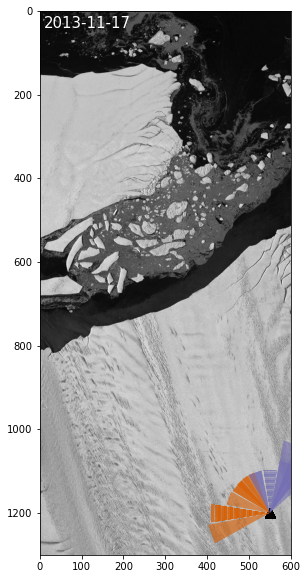

In [7]:
# set up images and plotting
fig = plt.figure(figsize = (10,10))
ax = plt.gca()
ax.set_xlim(left=0)
ax.set_xlim(right=600)
ax.set_ylim(bottom=1300)
ax.set_ylim(top=0)
img_artist = ax.imshow(image_list[0],cmap="Greys_r")
date_label = ax.text(10,40,date_strings[0],color="white",size=15)

# iterate through the dates of each image
for d in range(len(dates)):
    
    # load and plot the day's image
    img_artist.set_data(image_list[d])
    display.display(plt.gcf())
    date_label.set_text(date_strings[d])
        
    # if after 2012, start plotting backazimuths
    if dates[d] > datetime.datetime(2012,1,1):
        
        # get histogram of event backazimuths between date of last and current images
        window_start = dates[d-1]
        window_end = dates[d]
        rift_baz_idx = np.where((rift_times>=window_start)&(rift_times<window_end))[0]
        shear_baz_idx = np.where((shear_times>=window_start)&(shear_times<window_end))[0]
        rift_baz_hist, bins = np.histogram(rift_backazimuths[rift_baz_idx],bins=np.linspace(0,360,37))
        shear_baz_hist, bins = np.histogram(shear_backazimuths[shear_baz_idx],bins=np.linspace(0,360,37))
        # plot station location
        stat_x = 550 
        stat_y = 1200
        plt.scatter(stat_x,stat_y,marker="^",color="k",s=100)
        
        # plot backazimuth rays for rift
        rays = np.zeros((36,2),'float64')
        max_val = 1000
        max_len = 500
        min_len = 100
        max_width = 10
        for i in range(36):
            rays[i,:] = compute_rays(i*10)
            if rift_baz_hist[i] > 0:
                rayLength = min_len+rift_baz_hist[i]/max_val*(max_len-min_len)
                [x,y] = [np.linspace(stat_x,stat_x+rays[i,0]*rayLength,100),
                        np.linspace(stat_y,stat_y+rays[i,1]*rayLength,100)]
                lwidths=np.linspace(0,max_width,100)*rayLength/75
                points = np.array([x, y]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                lc = LineCollection(segments, linewidths=lwidths,color="#d95f02",alpha=0.75,gid=id)
                ax.add_collection(lc)

        # plot backazimuth rays for shear margin
        rays = np.zeros((36,2),'float64')
        max_val = 1000
        max_len = 500
        min_len = 100
        max_width = 10
        for i in range(36):
            rays[i,:] = compute_rays(i*10)
            if shear_baz_hist[i] > 0:
                rayLength = min_len+shear_baz_hist[i]/max_val*(max_len-min_len)
                [x,y] = [np.linspace(stat_x,stat_x+rays[i,0]*rayLength,100),
                        np.linspace(stat_y,stat_y+rays[i,1]*rayLength,100)]
                lwidths=np.linspace(0,max_width,100)*rayLength/75
                points = np.array([x, y]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                lc = LineCollection(segments, linewidths=lwidths,color="#7570b3",alpha=0.75,gid=id)
                ax.add_collection(lc)

    display.clear_output(wait=True)
    
    for c in ax.collections: 
        if c.get_gid() == id:
            c.remove()    